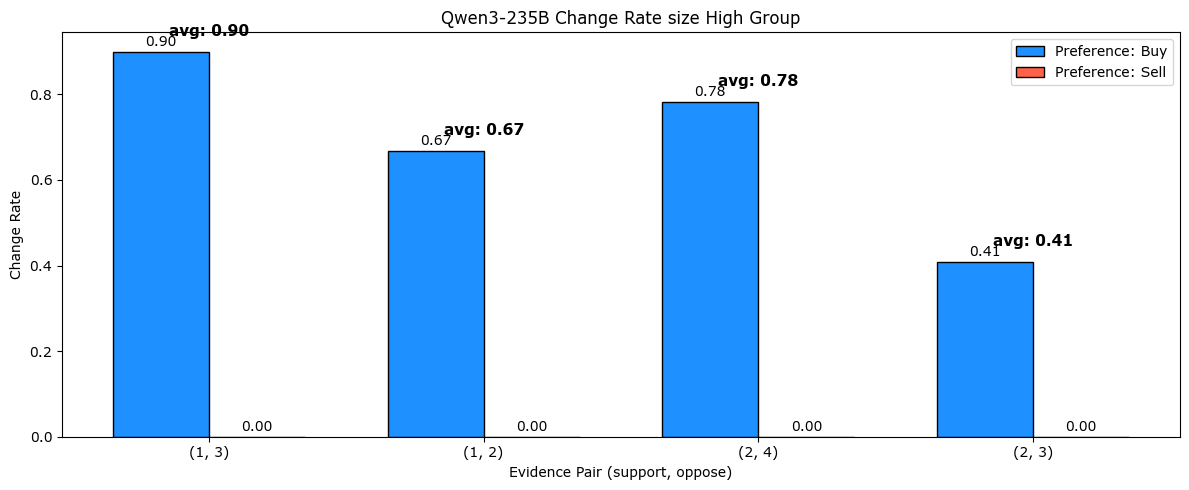

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#MODEL_NAME = 'DeepSeek-V3'

MODEL_NAME = 'Qwen3-235B'
CLASS = 'size'
bias_df = pd.read_csv(f"./final_result/{MODEL_NAME}_weight_evidence_{CLASS}.csv")

# 각 행마다 bias 변화 여부(1/0) 컬럼 추가
bias_df['changed'] = (bias_df['llm_answer'] != bias_df['original_bias']).astype(int)

# groupby: evidence_pair, original_bias별 change_rate 집계
change_df = (
    bias_df
    .groupby(['evidence_pair', 'original_bias'])['changed']
    .mean()
    .reset_index()
    .rename(columns={'changed': 'change_rate'})
)

# === 원하는 순서로 evidence_pair 지정 ===
evidence_pairs = [
    #(0, 2),  # 지지 0개, 반대 2개
    (1, 3),  # 지지 1개, 반대 3개
    (1, 2),  # 지지 1개, 반대 2개
    (2, 4),  # 지지 2개, 반대 4개
    (2, 3),  # 지지 2개, 반대 3개
]
evidence_pairs = [str(pair) for pair in evidence_pairs]  # 혹시 evidence_pair가 문자열이면

# 피벗: evidence_pair를 index로, original_bias를 컬럼으로
pivot = change_df.pivot(index='evidence_pair', columns='original_bias', values='change_rate').fillna(0)

# evidence_pairs 순서만 선택 (없는 경우 0으로 채움)
pivot = pivot.reindex(evidence_pairs, fill_value=0)

x = np.arange(len(pivot.index))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(x - width/2, pivot['buy'] if 'buy' in pivot.columns else np.zeros_like(x), 
               width, label='Preference: Buy', color='dodgerblue', edgecolor='k')
bars2 = ax.bar(x + width/2, pivot['sell'] if 'sell' in pivot.columns else np.zeros_like(x), 
               width, label='Preference: Sell', color='tomato', edgecolor='k')

# ---- 각 evidence_pair별 buy/sell 평균 표시 ----
for i, idx in enumerate(pivot.index):
    buy_val = pivot.loc[idx, 'buy'] if 'buy' in pivot.columns else 0
    sell_val = pivot.loc[idx, 'sell'] if 'sell' in pivot.columns else 0
    count = int('buy' in pivot.columns) + int('sell' in pivot.columns)
    pair_mean = (buy_val + sell_val) / count if count > 0 else 0
    max_height = max(buy_val, sell_val)
    ax.text(x[i], max_height + 0.03, f'avg: {pair_mean:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')
# --------------------------------------------

ax.set_title(f'{MODEL_NAME} Change Rate {CLASS} High Group')
ax.set_xlabel('Evidence Pair (support, oppose)')
ax.set_ylabel('Change Rate')
ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=0, ha='center')
ax.legend()
ax.bar_label(bars1, fmt='%.2f', padding=2)
ax.bar_label(bars2, fmt='%.2f', padding=2)
plt.tight_layout()
plt.show()

In [10]:
bias_df

,ticker,original_bias,trial,n_support_evidence,n_counter_evidence,evidence_pair,total_evidence,prompt,llm_output,llm_answer,changed
0,ABBV,buy,0,1,3,"(1, 3)",4,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""sell""...",sell,1
1,ABBV,buy,1,1,3,"(1, 3)",4,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""sell""...",sell,1
2,ABBV,buy,2,1,3,"(1, 3)",4,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""buy"",...",buy,0
3,ABBV,buy,3,1,3,"(1, 3)",4,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""sell""...",sell,1
4,ABBV,buy,4,1,3,"(1, 3)",4,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""sell""...",sell,1
...,...,...,...,...,...,...,...,...,...,...,...
875,WMT,buy,5,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""buy"",...",buy,0
876,WMT,buy,6,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""sell""...",sell,1
877,WMT,buy,7,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""sell""...",sell,1
878,WMT,buy,8,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"<think>\n\n</think>\n\n{\n ""decision"": ""sell""...",sell,1



Group sizes and standard deviations:
  evidence_pair original_bias  change_rate   std_dev  sample_size
0        (1, 2)           buy       0.7000  0.213809            8
1        (1, 3)           buy       0.9750  0.046291            8
2        (2, 3)           buy       0.5875  0.229518            8
3        (2, 4)           buy       0.8750  0.148805            8


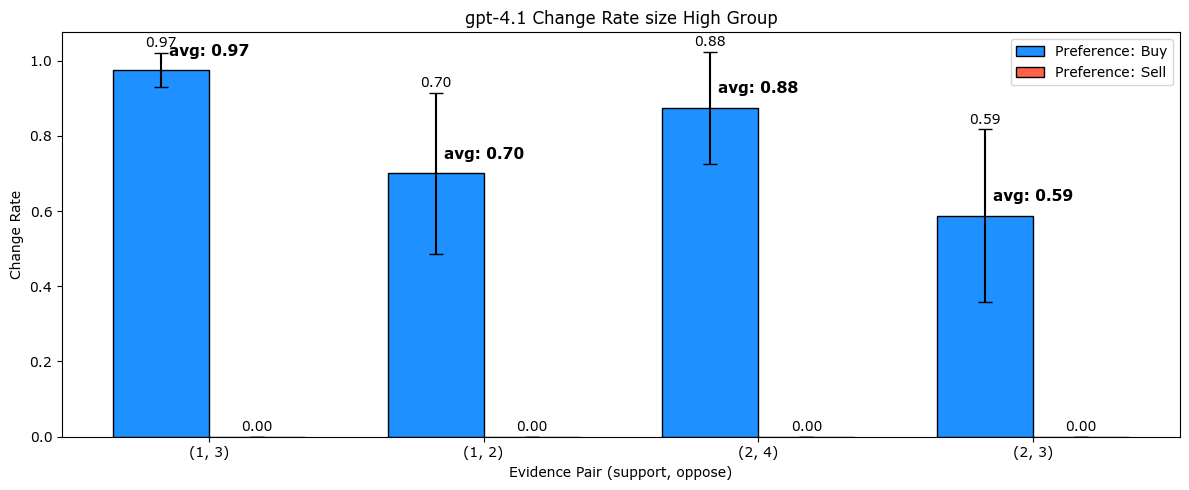

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

MODEL_NAME = 'gpt-4.1'
CLASS = 'size'

# 데이터 읽기
bias_df = pd.read_csv(f"./final_result/{MODEL_NAME}_weight_evidence_{CLASS}.csv")

# changed 컬럼 생성
bias_df['changed'] = (bias_df['llm_answer'] != bias_df['original_bias']).astype(int)

# stock, evidence_pair, original_bias별로 change_rate 계산
stock_change_df = (
    bias_df
    .groupby(['ticker', 'evidence_pair', 'original_bias'])['changed']
    .mean()
    .reset_index()
    .rename(columns={'changed': 'change_rate'})
)

# evidence_pair, original_bias별로 change_rate의 평균과 표준편차 계산
change_df = (
    stock_change_df
    .groupby(['evidence_pair', 'original_bias'])['change_rate']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'change_rate', 'std': 'std_dev', 'count': 'sample_size'})
)

# 데이터 검증: 표준편차와 샘플 수 출력
print("\nGroup sizes and standard deviations:")
print(change_df[['evidence_pair', 'original_bias', 'change_rate', 'std_dev', 'sample_size']])

# 이상치 확인
if (change_df['std_dev'] > 1).any():
    print("Warning: Standard deviation exceeds 1, which may indicate high variability!")
    print(change_df[change_df['std_dev'] > 1][['evidence_pair', 'original_bias', 'std_dev', 'sample_size']])

# 원하는 evidence_pair 순서
evidence_pairs = [
    (1, 3),  # 지지 1개, 반대 3개
    (1, 2),  # 지지 1개, 반대 2개
    (2, 4),  # 지지 2개, 반대 4개
    (2, 3),  # 지지 2개, 반대 3개
]
evidence_pairs = [str(pair) for pair in evidence_pairs]

# 피벗: change_rate와 std_dev
pivot_mean = change_df.pivot(index='evidence_pair', columns='original_bias', values='change_rate').fillna(0)
pivot_std = change_df.pivot(index='evidence_pair', columns='original_bias', values='std_dev').fillna(0)

# evidence_pairs 순서로 재정렬
pivot_mean = pivot_mean.reindex(evidence_pairs, fill_value=0)
pivot_std = pivot_std.reindex(evidence_pairs, fill_value=0)

# 플롯 설정
x = np.arange(len(pivot_mean.index))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))

# 바 플롯과 에러바
bars1 = ax.bar(
    x - width/2, 
    pivot_mean['buy'] if 'buy' in pivot_mean.columns else np.zeros_like(x), 
    width, 
    yerr=pivot_std['buy'] if 'buy' in pivot_std.columns else np.zeros_like(x), 
    label='Preference: Buy', 
    color='dodgerblue', 
    edgecolor='k',
    capsize=5
)
bars2 = ax.bar(
    x + width/2, 
    pivot_mean['sell'] if 'sell' in pivot_mean.columns else np.zeros_like(x), 
    width, 
    yerr=pivot_std['sell'] if 'sell' in pivot_std.columns else np.zeros_like(x), 
    label='Preference: Sell', 
    color='tomato', 
    edgecolor='k',
    capsize=5
)

# 평균 표시
for i, idx in enumerate(pivot_mean.index):
    buy_val = pivot_mean.loc[idx, 'buy'] if 'buy' in pivot_mean.columns else 0
    sell_val = pivot_mean.loc[idx, 'sell'] if 'sell' in pivot_mean.columns else 0
    count = int('buy' in pivot_mean.columns) + int('sell' in pivot_mean.columns)
    pair_mean = (buy_val + sell_val) / count if count > 0 else 0
    max_height = max(buy_val, sell_val)
    ax.text(x[i], max_height + 0.03, f'avg: {pair_mean:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

# 플롯 커스터마이징
ax.set_title(f'{MODEL_NAME} Change Rate {CLASS} High Group')
ax.set_xlabel('Evidence Pair (support, oppose)')
ax.set_ylabel('Change Rate')
ax.set_xticks(x)
ax.set_xticklabels(pivot_mean.index, rotation=0, ha='center')
ax.legend()
ax.bar_label(bars1, fmt='%.2f', padding=2)
ax.bar_label(bars2, fmt='%.2f', padding=2)
plt.tight_layout()
plt.show()

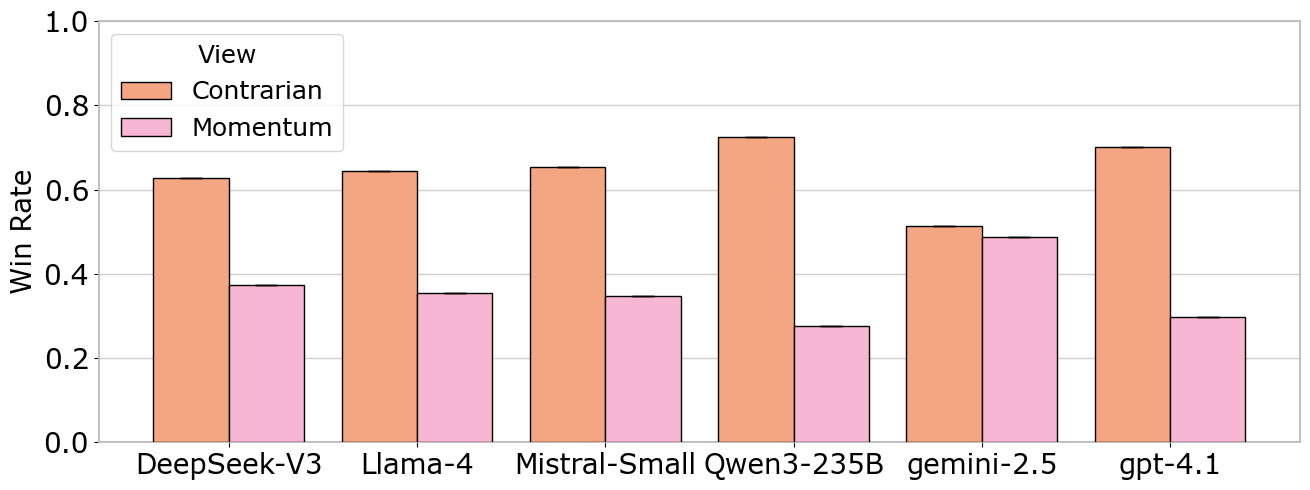

In [7]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

files = glob.glob("./final_result/*_mc.csv")
files = [f for f in files if '_weight_' not in f]
plt.rcParams['font.family'] = 'Verdana'

def get_model_name(filepath):
    basename = os.path.basename(filepath)
    model = basename.replace('_mc.csv', '')
    return model

results = []
views_set = set()

for file in files:
    model = get_model_name(file)
    temp = pd.read_csv(file)
    all_views = temp['buy'].unique().tolist()
    views_set.update(all_views)
    def get_decision_view(row):
        buy_view = row['buy']
        llm_answer = row['llm_answer']
        if pd.isnull(llm_answer):
            return None
        llm_answer = llm_answer.lower()
        other_view = [v for v in all_views if v != buy_view][0]
        if llm_answer == "buy":
            return buy_view
        elif llm_answer == "sell":
            return other_view
        else:
            return None
    temp['decision_view'] = temp.apply(get_decision_view, axis=1)

    winrate_by_view = (
        temp.groupby('decision_view')
            .size()
            .div(len(temp))
    )
    # std는 trial이 여러 번 있어야 의미 있지만, 여기선 0으로 둠
    for view in winrate_by_view.index:
        results.append({
            "model": model,
            "view": view,
            "mean": winrate_by_view[view],
            "std": 0
        })

views = sorted(list(views_set))
df_result = pd.DataFrame(results)

num_models = len(df_result['model'].unique())
num_views = len(views)
x = range(num_models)
width = 0.4

bar_colors = ['#f4a582', '#f7b6d2']

plt.figure(figsize=(2.2*num_models, 5))
plt.grid(axis='y', color='#bbbbbb', linewidth=1, linestyle='-', alpha=0.7, zorder=0)

for i, view in enumerate(views):
    data = df_result[df_result['view'] == view].sort_values('model')
    plt.bar(
        [p + (i - (num_views-1)/2)*width for p in x],
        data['mean'],
        width=width,
        yerr=data['std'],
        label=view.capitalize(),
        capsize=8,
        color=bar_colors[i % len(bar_colors)],
        edgecolor='black',
        zorder=3
    )

for spine in plt.gca().spines.values():
    spine.set_edgecolor('#bbbbbb')
    spine.set_linewidth(1.3)

plt.xticks(x, sorted(df_result['model'].unique()), fontsize=20)
plt.ylim(0, 1)
plt.yticks(fontsize=20)
plt.ylabel("Win Rate", fontsize=20)
plt.legend(title="View", fontsize=18, title_fontsize=18, frameon=True)
plt.tight_layout()
plt.savefig("winrate_plot.pdf", bbox_inches='tight', dpi=500)
plt.show()

In [36]:
# 데이터 불러오기

df = pd.read_csv(f'./final_result/gemini-2.5_equal_evidence.csv')

# ticker+sector별 집계
group_df = df.groupby(['ticker', 'name', 'sector']).agg(
    buy_count=('llm_answer', lambda x: (x.str.lower() == 'buy').sum()),
    sell_count=('llm_answer', lambda x: (x.str.lower() == 'sell').sum())
).reset_index()

group_df['total_count'] = group_df['buy_count'] + group_df['sell_count']
group_df['preference'] = (group_df['sell_count'] - group_df['buy_count']).abs() / group_df['total_count']
group_df['buy_ratio'] = group_df['buy_count'] / group_df['total_count']

# 섹터별 preference의 평균과 표준편차 계산
sector_stats = group_df.groupby('sector').agg(
    preference_mean=('preference', 'mean'),
    preference_std=('preference', 'std')
).reset_index()

# 결과 출력
print(sector_stats)

                    sector  preference_mean  preference_std
0          Basic Materials         0.333333        0.342540
1   Communication Services         0.455556        0.289466
2        Consumer Cyclical         0.425000        0.278675
3       Consumer Defensive         0.357576        0.281769
4                   Energy         0.536842        0.240856
5       Financial Services         0.420000        0.286889
6               Healthcare         0.488462        0.297476
7              Industrials         0.492063        0.295832
8              Real Estate         0.333333        0.248069
9               Technology         0.503448        0.324965
10               Utilities         0.392857        0.333254


In [9]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency
import os
import numpy as np

# 디렉토리 경로 설정
directory = '/Users/hobbang/Desktop/bias/final_result/'
OUTPUT_CSV = './ttest_results.csv'  # 출력 CSV 파일 경로
ALPHA = 0.05  # 유의수준

# CSV 파일 목록 (_equal_evidence.csv와 정확히 mc.csv로 끝나는 파일 로드)
files = [f for f in os.listdir(directory) if (f.endswith('_equal_evidence.csv') or (f.endswith('mc.csv') and 'weight' not in f))]

# 결과를 저장할 데이터프레임 초기화
results = []

for file in files:
    # 모델 이름 및 분석 타입 추출
    if file.endswith('_equal_evidence.csv'):
        MODEL_NAME = file.replace('_equal_evidence.csv', '')
        analysis_type = 'equal_evidence'
    elif file.endswith('mc.csv'):
        MODEL_NAME = file.replace('mc.csv', '').rstrip('_')
        analysis_type = 'momentum'
    
    # CSV 파일 경로
    csv_path = os.path.join(directory, file)
    
    # 파일 존재 여부 확인
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} does not exist. Skipping {MODEL_NAME}.")
        continue

    # 데이터 읽기
    df = pd.read_csv(csv_path)

    # llm_answer를 문자열로 변환하여 안전하게 처리
    df['llm_answer'] = df['llm_answer'].astype(str)

    if analysis_type == 'equal_evidence':
        # 그룹화 및 선호도 계산
        group_df = df.groupby(['ticker', 'name', 'sector', 'marketcap']).agg(
            buy_count=('llm_answer', lambda x: (x.str.lower() == 'buy').sum()),
            sell_count=('llm_answer', lambda x: (x.str.lower() == 'sell').sum())
        ).reset_index()

        group_df['total_count'] = group_df['buy_count'] + group_df['sell_count']
        group_df['preference'] = group_df.apply(
            lambda row: abs(row['sell_count'] - row['buy_count']) / row['total_count'] if row['total_count'] > 0 else 0,
            axis=1
        )

        # --- 1. 섹터(Sector) 기반 T-test ---
        sector_stats = group_df.groupby('sector').agg(
            preference_mean=('preference', 'mean'),
            preference_std=('preference', 'std'),
            sample_size=('preference', 'count')
        ).reset_index()

        # 가장 선호도가 높은/낮은 섹터 찾기
        highest_sector_name = sector_stats.loc[sector_stats['preference_mean'].idxmax()]['sector']
        lowest_sector_name = sector_stats.loc[sector_stats['preference_mean'].idxmin()]['sector']
        high_prefer_value = sector_stats.loc[sector_stats['preference_mean'].idxmax()]['preference_mean']
        low_prefer_value = sector_stats.loc[sector_stats['preference_mean'].idxmin()]['preference_mean']

        # T-test 데이터 추출
        high_sector_data = group_df[group_df['sector'] == highest_sector_name]['preference']
        low_sector_data = group_df[group_df['sector'] == lowest_sector_name]['preference']

        # 샘플 크기 계산
        sample_size_sector = len(high_sector_data) + len(low_sector_data)

        # T-test 수행
        t_stat_sector, p_value_sector = ttest_ind(high_sector_data, low_sector_data, equal_var=False)

        # mean_diff 계산
        mean_diff_sector = high_prefer_value - low_prefer_value

        # 결과 저장
        results.append({
            'model': MODEL_NAME,
            'class': 'sector',
            # 't_stat': t_stat_sector,
            'p_value': p_value_sector,
            'sample_size': sample_size_sector,
            'high_prefer': highest_sector_name,
            'low_prefer': lowest_sector_name,
            'mean_diff': mean_diff_sector
        })

        # --- 2. 시가총액(Market Cap) 기반 T-test ---
        group_df['marketcap_quartile'] = pd.qcut(group_df['marketcap'], q=4, labels=['Q4', 'Q3', 'Q2', 'Q1'])

        # 시가총액 사분위수별 선호도 평균 계산
        quartile_stats = group_df.groupby('marketcap_quartile').agg(
            preference_mean=('preference', 'mean')
        ).reset_index()

        # 가장 선호도가 높은/낮은 사분위수 찾기
        highest_quartile = quartile_stats.loc[quartile_stats['preference_mean'].idxmax()]['marketcap_quartile']
        lowest_quartile = quartile_stats.loc[quartile_stats['preference_mean'].idxmin()]['marketcap_quartile']
        high_prefer_value = quartile_stats.loc[quartile_stats['preference_mean'].idxmax()]['preference_mean']
        low_prefer_value = quartile_stats.loc[quartile_stats['preference_mean'].idxmin()]['preference_mean']

        # T-test 데이터 추출
        high_size_data = group_df[group_df['marketcap_quartile'] == highest_quartile]['preference']
        low_size_data = group_df[group_df['marketcap_quartile'] == lowest_quartile]['preference']

        # 샘플 크기 계산
        sample_size_size = len(high_size_data) + len(low_size_data)

        # T-test 수행
        t_stat_size, p_value_size = ttest_ind(high_size_data, low_size_data, equal_var=False)

        # mean_diff 계산
        mean_diff_size = high_prefer_value - low_prefer_value

        # 결과 저장
        results.append({
            'model': MODEL_NAME,
            'class': 'size',
            # 't_stat': t_stat_size,
            'p_value': p_value_size,
            'sample_size': sample_size_size,
            'high_prefer': highest_quartile,
            'low_prefer': lowest_quartile,
            'mean_diff': mean_diff_size
        })

    elif analysis_type == 'momentum':
        # --- 모멘텀(Momentum) 기반 카이제곱 검정 ---
        # decision_view 컬럼 생성
        df['decision_view'] = df.apply(
            lambda row: row['buy'] if row['llm_answer'].lower() == 'buy' else row['sell'] if row['llm_answer'].lower() == 'sell' else None,
            axis=1
        )

        # NaN 값 제거
        df = df.dropna(subset=['decision_view'])

        # 티커별로 decision_view의 빈도 계산
        group_df = df.groupby(['ticker', 'decision_view']).size().unstack(fill_value=0).reset_index()
        group_df['total_count'] = group_df.get('contrarian', 0) + group_df.get('momentum', 0)
        group_df['contrarian_win_rate'] = group_df.get('contrarian', 0) / group_df['total_count'].where(group_df['total_count'] > 0, 1)
        group_df['momentum_win_rate'] = group_df.get('momentum', 0) / group_df['total_count'].where(group_df['total_count'] > 0, 1)

        # contrarian과 momentum의 win_rate 데이터 추출
        contrarian_win_rates = group_df['contrarian_win_rate']
        momentum_win_rates = group_df['momentum_win_rate']

        # 평균 win_rate 계산
        mean_contrarian = contrarian_win_rates.mean() if not contrarian_win_rates.empty else 0
        mean_momentum = momentum_win_rates.mean() if not momentum_win_rates.empty else 0

        # 높은/낮은 그룹 결정
        if mean_contrarian > mean_momentum:
            high_group = 'contrarian'
            low_group = 'momentum'
            high_prefer_value = mean_contrarian
            low_prefer_value = mean_momentum
        else:
            high_group = 'momentum'
            low_group = 'contrarian'
            high_prefer_value = mean_momentum
            low_prefer_value = mean_contrarian

        # 카이제곱 검정을 위한 분할표 생성
        contingency_table = df.groupby(['decision_view', 'llm_answer']).size().unstack(fill_value=0)
        if 'contrarian' in contingency_table.index and 'momentum' in contingency_table.index:
            chi2_table = contingency_table.loc[['contrarian', 'momentum'], ['buy', 'sell']].values
            sample_size_momentum = int(contingency_table.loc[['contrarian', 'momentum'], ['buy', 'sell']].sum().sum())
        else:
            chi2_table = None
            sample_size_momentum = 0

        # 카이제곱 검정 수행
        if chi2_table is not None and chi2_table.shape == (2, 2) and chi2_table.min() > 0:
            chi2_stat, p_value_momentum, _, _ = chi2_contingency(chi2_table)
        else:
            chi2_stat, p_value_momentum = np.nan, np.nan

        # mean_diff 계산
        mean_diff_momentum = high_prefer_value - low_prefer_value

        # 결과 저장
        results.append({
            'model': MODEL_NAME,
            'class': 'momentum',
            # 't_stat': chi2_stat,  # 카이제곱 통계량을 t_stat 컬럼에 저장
            'p_value': p_value_momentum,
            'sample_size': sample_size_momentum,
            'high_prefer': high_group,
            'low_prefer': low_group,
            'mean_diff': mean_diff_momentum
        })

# 결과 데이터프레임 생성 및 CSV 저장
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='model')
results_df.to_csv(OUTPUT_CSV, index=False)
print(f"\nResults saved to {OUTPUT_CSV}")
print(results_df)

/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/273490790.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile').agg(
/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/273490790.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile').agg(
/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/273490790.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh


Results saved to ./ttest_results.csv
            model     class       p_value  sample_size      high_prefer  \
11    DeepSeek-V3      size  5.142556e-07          214               Q1   
9     DeepSeek-V3  momentum  2.877659e-18         1708       contrarian   
10    DeepSeek-V3    sector  1.379350e-02           79       Technology   
15        Llama-4      size  1.494970e-02          213               Q2   
14        Llama-4    sector  5.043332e-04           52           Energy   
16        Llama-4  momentum  6.086756e-25         1706       contrarian   
17  Mistral-Small  momentum  5.785183e-01         1708       contrarian   
4   Mistral-Small    sector  1.244343e-01           39  Basic Materials   
5   Mistral-Small      size  5.427972e-02          214               Q1   
13     Qwen3-235B      size  4.814286e-03          214               Q1   
12     Qwen3-235B    sector  2.845715e-03           76        Utilities   
0      Qwen3-235B  momentum  3.659317e-01         1706       c

/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/273490790.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile').agg(


In [1]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency
import os
import numpy as np

# 디렉토리 경로 설정
directory = '/Users/hobbang/Desktop/bias/final_result/'
OUTPUT_CSV = './statistical_analysis_results.csv'  # 출력 CSV 파일 경로
ALPHA = 0.05  # 유의수준

# CSV 파일 목록 (_equal_evidence.csv와 정확히 mc.csv로 끝나는 파일 로드)
files = [f for f in os.listdir(directory) if (f.endswith('_equal_evidence.csv') or (f.endswith('mc.csv') and 'weight' not in f))]

# 결과를 저장할 리스트 초기화
results = []

for file in files:
    # 모델 이름 및 분석 타입 추출
    if file.endswith('_equal_evidence.csv'):
        MODEL_NAME = file.replace('_equal_evidence.csv', '')
        analysis_type = 'equal_evidence'
    elif file.endswith('mc.csv'):
        MODEL_NAME = file.replace('mc.csv', '').rstrip('_')
        analysis_type = 'momentum'
    
    # CSV 파일 경로
    csv_path = os.path.join(directory, file)
    
    # 파일 존재 여부 확인
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} does not exist. Skipping {MODEL_NAME}.")
        continue

    # 데이터 읽기
    df = pd.read_csv(csv_path)

    # llm_answer를 문자열로 변환하여 안전하게 처리
    df['llm_answer'] = df['llm_answer'].astype(str)

    if analysis_type == 'equal_evidence':
        # --- Equal Evidence 분석 (기존 코드와 동일) ---
        group_df = df.groupby(['ticker', 'name', 'sector', 'marketcap']).agg(
            buy_count=('llm_answer', lambda x: (x.str.lower() == 'buy').sum()),
            sell_count=('llm_answer', lambda x: (x.str.lower() == 'sell').sum())
        ).reset_index()

        group_df['total_count'] = group_df['buy_count'] + group_df['sell_count']
        group_df['preference'] = group_df.apply(
            lambda row: abs(row['sell_count'] - row['buy_count']) / row['total_count'] if row['total_count'] > 0 else 0,
            axis=1
        )
        
        # 1. 섹터(Sector) 기반 T-test
        sector_stats = group_df.groupby('sector')['preference'].agg(['mean', 'std', 'count']).reset_index()
        highest_sector = sector_stats.loc[sector_stats['mean'].idxmax()]
        lowest_sector = sector_stats.loc[sector_stats['mean'].idxmin()]
        high_sector_data = group_df[group_df['sector'] == highest_sector['sector']]['preference']
        low_sector_data = group_df[group_df['sector'] == lowest_sector['sector']]['preference']
        t_stat_sector, p_value_sector = ttest_ind(high_sector_data, low_sector_data, equal_var=False)
        results.append({
            'model': MODEL_NAME, 'class': 'sector', 't_stat': t_stat_sector, 'p_value': p_value_sector,
            'sample_size': len(high_sector_data) + len(low_sector_data),
            'high_prefer': highest_sector['sector'], 'low_prefer': lowest_sector['sector'],
            'mean_diff': highest_sector['mean'] - lowest_sector['mean']
        })

        # 2. 시가총액(Market Cap) 기반 T-test
        group_df['marketcap_quartile'] = pd.qcut(group_df['marketcap'], q=4, labels=['Q4', 'Q3', 'Q2', 'Q1'])
        quartile_stats = group_df.groupby('marketcap_quartile')['preference'].agg(['mean']).reset_index()
        highest_quartile = quartile_stats.loc[quartile_stats['mean'].idxmax()]
        lowest_quartile = quartile_stats.loc[quartile_stats['mean'].idxmin()]
        high_size_data = group_df[group_df['marketcap_quartile'] == highest_quartile['marketcap_quartile']]['preference']
        low_size_data = group_df[group_df['marketcap_quartile'] == lowest_quartile['marketcap_quartile']]['preference']
        t_stat_size, p_value_size = ttest_ind(high_size_data, low_size_data, equal_var=False)
        results.append({
            'model': MODEL_NAME, 'class': 'size', 't_stat': t_stat_size, 'p_value': p_value_size,
            'sample_size': len(high_size_data) + len(low_size_data),
            'high_prefer': highest_quartile['marketcap_quartile'], 'low_prefer': lowest_quartile['marketcap_quartile'],
            'mean_diff': highest_quartile['mean'] - lowest_quartile['mean']
        })
        # (콘솔 출력 부분은 생략)

    elif analysis_type == 'momentum':
        # --- 모멘텀(Momentum) 기반 카이제곱 검정 (수정된 로직) ---
        df['decision_view'] = df.apply(
            lambda row: row['buy'] if row['llm_answer'].lower() == 'buy' else row['sell'] if row['llm_answer'].lower() == 'sell' else None,
            axis=1
        )
        df.dropna(subset=['decision_view'], inplace=True)

        # 카이제곱 검정을 위한 분할표 생성
        contingency_table = pd.crosstab(df['decision_view'], df['llm_answer'])

        # 초기화
        chi2_stat, p_value_momentum = np.nan, np.nan
        high_group, low_group = 'N/A', 'N/A'
        high_rate, low_rate = 0, 0
        sample_size_momentum = 0
        
        # 분할표가 2x2 형태를 갖추고 있는지 확인
        if 'contrarian' in contingency_table.index and 'momentum' in contingency_table.index and \
           'buy' in contingency_table.columns and 'sell' in contingency_table.columns:
            
            chi2_table = contingency_table.loc[['contrarian', 'momentum'], ['buy', 'sell']].values
            sample_size_momentum = int(chi2_table.sum())
            
            if chi2_table.min() > 0: # 모든 셀의 값이 0보다 커야 함
                chi2_stat, p_value_momentum, _, _ = chi2_contingency(chi2_table)

            # 전체 승률(buy 비율) 계산
            contrarian_total = chi2_table[0].sum()
            momentum_total = chi2_table[1].sum()
            
            overall_contrarian_rate = chi2_table[0, 0] / contrarian_total if contrarian_total > 0 else 0
            overall_momentum_rate = chi2_table[1, 0] / momentum_total if momentum_total > 0 else 0
            
            # 높은/낮은 그룹 결정
            if overall_contrarian_rate > overall_momentum_rate:
                high_group, low_group = 'contrarian', 'momentum'
                high_rate, low_rate = overall_contrarian_rate, overall_momentum_rate
            else:
                high_group, low_group = 'momentum', 'contrarian'
                high_rate, low_rate = overall_momentum_rate, overall_contrarian_rate
        
        # 결과 저장
        results.append({
            'model': MODEL_NAME,
            'class': 'momentum',
            't_stat': chi2_stat,  # 카이제곱 통계량을 t_stat 컬럼에 저장
            'p_value': p_value_momentum,
            'sample_size': sample_size_momentum,
            'high_prefer': high_group,
            'low_prefer': low_group,
            'mean_diff': high_rate - low_rate
        })

        # 콘솔 출력
        print(f"\n### Model: {MODEL_NAME} (Momentum)")
        print("## Momentum-based Chi-Square Test")
        if high_group != 'N/A':
            print(f"Comparison: '{high_group}' (Overall Win Rate: {high_rate:.4f}) vs '{low_group}' (Overall Win Rate: {low_rate:.4f})")
            print(f"Chi2-statistic: {chi2_stat:.4f}, P-value: {p_value_momentum:.4f}, Sample Size: {sample_size_momentum}")
            conclusion = "Significant difference" if not np.isnan(p_value_momentum) and p_value_momentum < ALPHA else "No significant difference"
            print(f"Conclusion: {conclusion} (p < {ALPHA})")
        else:
            print("Could not perform Chi-Square test due to insufficient data in the contingency table.")


# 결과 데이터프레임 생성 및 CSV 저장
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['model', 'class']).reset_index(drop=True)
results_df.to_csv(OUTPUT_CSV, index=False, float_format='%.4f')

print(f"\nResults saved to {OUTPUT_CSV}")
print(results_df)


### Model: Qwen3-235B (Momentum)
## Momentum-based Chi-Square Test
Comparison: 'momentum' (Overall Win Rate: 0.5404) vs 'contrarian' (Overall Win Rate: 0.5084)
Chi2-statistic: 0.8174, P-value: 0.3659, Sample Size: 1706
Conclusion: No significant difference (p < 0.05)


/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/157383332.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile')['preference'].agg(['mean']).reset_index()



### Model: gpt-4.1 (Momentum)
## Momentum-based Chi-Square Test
Comparison: 'contrarian' (Overall Win Rate: 0.4087) vs 'momentum' (Overall Win Rate: 0.2849)
Chi2-statistic: 22.9208, P-value: 0.0000, Sample Size: 1708
Conclusion: Significant difference (p < 0.05)


/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/157383332.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile')['preference'].agg(['mean']).reset_index()



### Model: gemini-2.5 (Momentum)
## Momentum-based Chi-Square Test
Comparison: 'momentum' (Overall Win Rate: 0.6931) vs 'contrarian' (Overall Win Rate: 0.6830)
Chi2-statistic: 0.1595, P-value: 0.6896, Sample Size: 1708
Conclusion: No significant difference (p < 0.05)


/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/157383332.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile')['preference'].agg(['mean']).reset_index()



### Model: DeepSeek-V3 (Momentum)
## Momentum-based Chi-Square Test
Comparison: 'momentum' (Overall Win Rate: 0.9215) vs 'contrarian' (Overall Win Rate: 0.7507)
Chi2-statistic: 75.9717, P-value: 0.0000, Sample Size: 1708
Conclusion: Significant difference (p < 0.05)


/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/157383332.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile')['preference'].agg(['mean']).reset_index()
/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/157383332.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile')['preference'].agg(['mean']).reset_index()



### Model: Llama-4 (Momentum)
## Momentum-based Chi-Square Test
Comparison: 'momentum' (Overall Win Rate: 0.9488) vs 'contrarian' (Overall Win Rate: 0.7464)
Chi2-statistic: 106.3800, P-value: 0.0000, Sample Size: 1706
Conclusion: Significant difference (p < 0.05)

### Model: Mistral-Small (Momentum)
## Momentum-based Chi-Square Test
Comparison: 'momentum' (Overall Win Rate: 0.5329) vs 'contrarian' (Overall Win Rate: 0.5175)
Chi2-statistic: 0.3086, P-value: 0.5785, Sample Size: 1708
Conclusion: No significant difference (p < 0.05)

Results saved to ./statistical_analysis_results.csv
            model     class      t_stat       p_value  sample_size  \
0     DeepSeek-V3  momentum   75.971655  2.877659e-18         1708   
1     DeepSeek-V3    sector    2.633941  1.379350e-02           79   
2     DeepSeek-V3      size    5.189367  5.142556e-07          214   
3         Llama-4  momentum  106.380045  6.086756e-25         1706   
4         Llama-4    sector    3.749382  5.043332e-04       

/var/folders/b2/tkzy89rs579_7rjdd995bmhh0000gn/T/ipykernel_7538/157383332.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = group_df.groupby('marketcap_quartile')['preference'].agg(['mean']).reset_index()


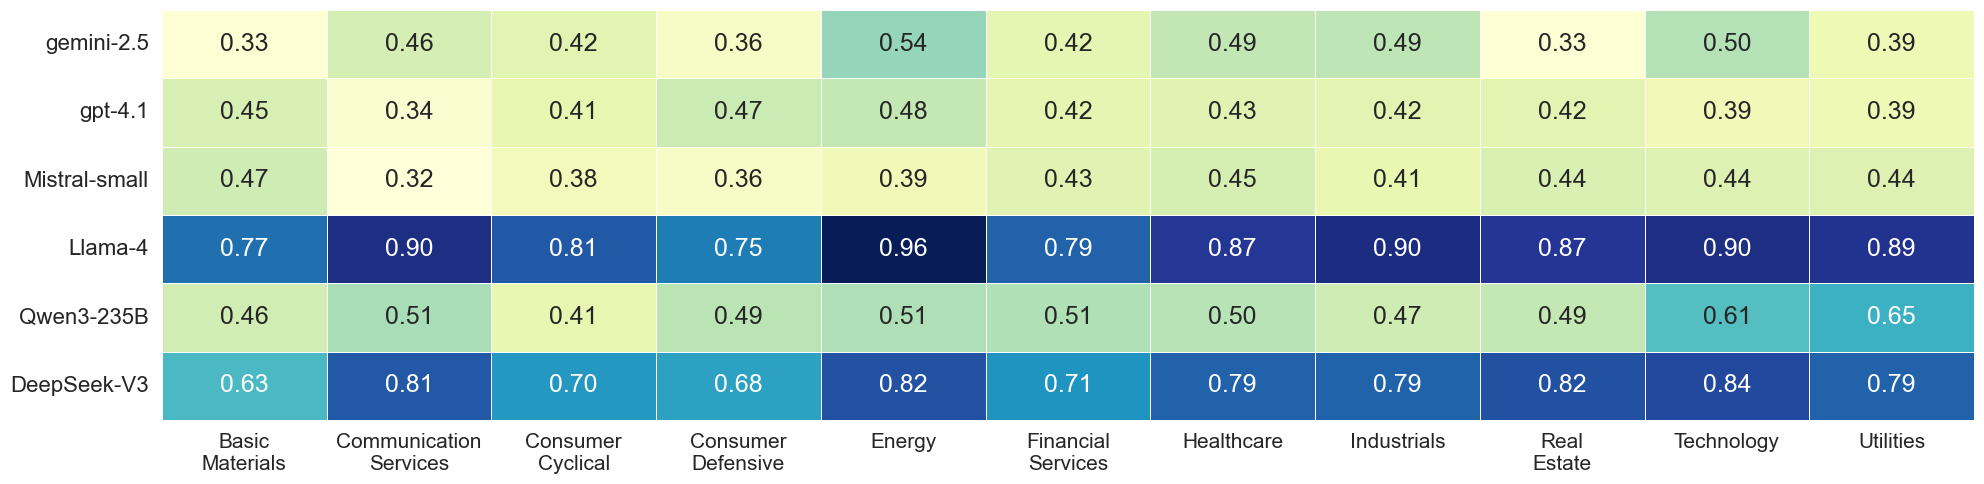

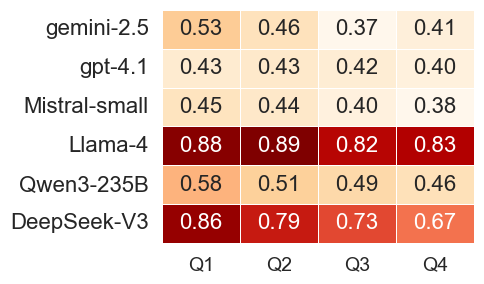

Heatmaps displayed.


In [111]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 디렉토리 경로 설정 (사용자 환경에 맞게 수정)
directory = '/Users/hobbang/Desktop/bias/final_result/'

# JSON 파일 목록 (디렉토리 내 모든 _bias_summary.json 파일 로드)
files = [f for f in os.listdir(directory) if f.endswith('_bias_summary.json')]

# 섹터 바이어스 데이터를 위한 딕셔너리 리스트
sector_data = []
# 사이즈 바이어스 데이터를 위한 딕셔너리 리스트
size_data = []

for file in files:
    filepath = os.path.join(directory, file)
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # 모델 이름 추출 (파일명에서 _bias_summary.json 제거)
    model_name = file.split('_bias_summary.json')[0]
    
    # 섹터 바이어스 preference 추출
    sector_prefs = {sector: info['preference'] for sector, info in data['sector_bias'].items()}
    sector_prefs['model'] = model_name
    sector_data.append(sector_prefs)
    
    # 사이즈 바이어스 preference 추출
    size_prefs = {size: info['preference'] for size, info in data['size_bias'].items()}
    size_prefs['model'] = model_name
    size_data.append(size_prefs)

# 섹터 데이터프레임 생성
sector_df = pd.DataFrame(sector_data)
sector_df = sector_df.set_index('model')
sector_df.index.name = None  # y축 인덱스 이름 제거

# 사이즈 데이터프레임 생성
size_df = pd.DataFrame(size_data)
size_df = size_df.set_index('model')
size_df.index.name = None  # y축 인덱스 이름 제거

# 모델 순서 정의 (테이블 순서에 맞게)
model_order = ['gemini-2.5', 'gpt-4.1', 'Mistral-small', 'Llama-4', 'Qwen3-235B', 'DeepSeek-V3']

# 행 재정렬
sector_df = sector_df.reindex(model_order)
size_df = size_df.reindex(model_order)

# 섹터 컬럼 알파벳 순으로 정렬
sector_df = sector_df[sorted(sector_df.columns)]

# 사이즈 컬럼은 Q1, Q2, Q3, Q4 순서 가정
size_columns_order = ["Q1", "Q2", "Q3", "Q4"]
size_df = size_df[size_columns_order]

# 히트맵 스타일 설정
sns.set_theme(style="whitegrid")

# 섹터 이름 라벨 수정: 스페이스를 \n으로 변경
sector_labels = [col.replace(' ', '\n') for col in sector_df.columns]

# 섹터 바이어스 히트맵
plt.figure(figsize=(20, 5))
ax = sns.heatmap(sector_df, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5, annot_kws={"size": 18}, cbar=False)
plt.xticks(ticks=np.arange(len(sector_df.columns)) + 0.5, labels=sector_labels, rotation=0, fontsize=15)
plt.yticks(fontsize=16)
plt.ylabel('')  # y축 레이블 제거
plt.tight_layout()
plt.savefig("sector_plot.pdf")
plt.show()

# 사이즈 바이어스 히트맵
plt.figure(figsize=(5, 3))
ax = sns.heatmap(size_df, annot=True, cmap='OrRd', fmt=".2f", linewidths=.5, annot_kws={"size": 16}, cbar=False)
plt.xticks(ticks=np.arange(len(size_df.columns)) + 0.5, labels=size_df.columns, rotation=0, fontsize=14)
plt.yticks(fontsize=16)
plt.ylabel('')  # y축 레이블 제거
plt.tight_layout()
plt.savefig("size_plot.pdf")
plt.show()

print("Heatmaps displayed.")

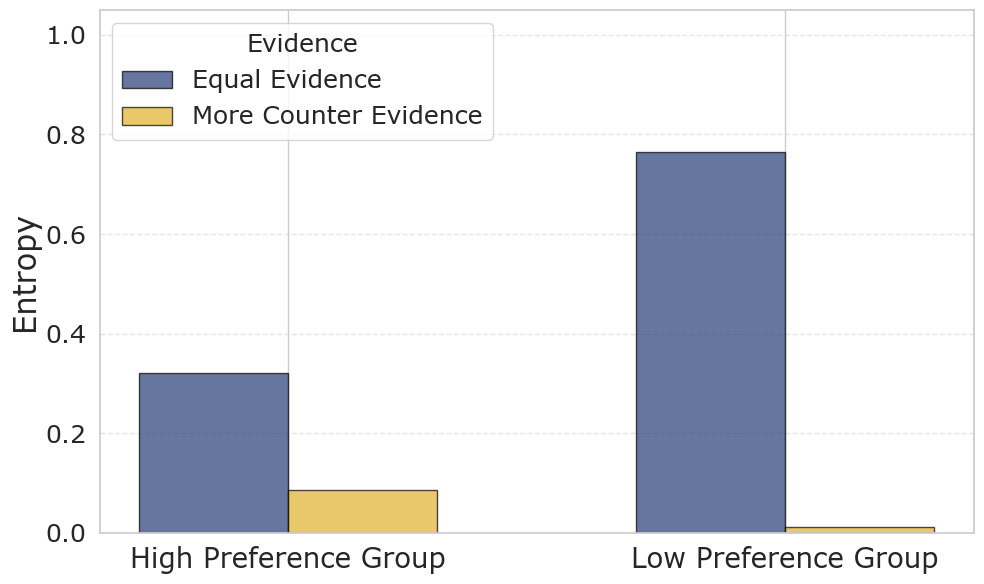

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

plt.rcParams['font.family'] = 'Verdana'


# Load the two CSV files
prefer_df = pd.read_csv("/Users/hobbang/Desktop/bias/final_result/DeepSeek-V3-prefer-prob.csv")
no_prefer_df = pd.read_csv("/Users/hobbang/Desktop/bias/final_result/DeepSeek-V3-no-prefer-prob.csv")

# Add a group column to each
prefer_df['group'] = 'High Preference Group'
no_prefer_df['group'] = 'Low Preference Group'

# Combine the dataframes
df = pd.concat([prefer_df, no_prefer_df], ignore_index=True)

# Normalize probabilities
df['prob_buy_norm'] = df['prob_buy'] / (df['prob_buy'] + df['prob_sell'])
df['prob_sell_norm'] = df['prob_sell'] / (df['prob_buy'] + df['prob_sell'])

# Calculate entropy
df['entropy'] = df.apply(lambda row: entropy([row['prob_buy_norm'], row['prob_sell_norm']], base=2), axis=1)

# Group by 'group' and 'evidence_pair' to get mean entropy
grouped = df.groupby(['group', 'evidence_pair'])['entropy'].mean().reset_index()

# Map evidence_pair to more descriptive labels
label_map = {
    '(2, 2)': 'Equal Evidence',
    '(2, 3)': 'More Counter Evidence'
}
grouped['evidence_label'] = grouped['evidence_pair'].map(label_map)

# Use pivot_table instead of pivot to handle any potential aggregation needs
pivot_df = grouped.pivot_table(index='group', columns='evidence_label', values='entropy', aggfunc='mean')

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width and positions
bar_width = 0.3
indices = np.arange(len(pivot_df.index))

# Get unique evidence_labels (sorted)
evidence_labels = sorted(pivot_df.columns)
colors = ['#273c75', '#e1b12c']  # Deep navy & Citrus yellow

for i, label in enumerate(evidence_labels):
    values = pivot_df[label]
    ax.bar(indices + i * bar_width, values, bar_width, label=label, color=colors[i], edgecolor='black', alpha=0.7)

ax.set_ylabel('Entropy', fontsize=22)
plt.yticks(fontsize=18)

ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(pivot_df.index, fontsize=20)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotations with rounded box
# for i, label in enumerate(evidence_labels):
#     for j, val in enumerate(pivot_df[label]):
#         ax.text(j + i * bar_width, val + 0.02, f"{val:.3f}", ha='center', fontsize=15,
#                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

ax.legend(title='Evidence', fontsize=18, title_fontsize=18, loc='upper left')
plt.tight_layout()
plt.savefig("entropy.pdf")
plt.show()

In [7]:
df

,ticker,original_bias,trial,n_support_evidence,n_counter_evidence,evidence_pair,total_evidence,prompt,llm_output,llm_answer,prob_buy,prob_sell,delta_prob,model,prob_buy_norm,prob_sell_norm,entropy
0,IR,buy,0,2,2,"(2, 2)",4,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C4RV7-28Eivz-96394e33fddaaa77"",\...",buy,0.000002,0.000002,0.000000,DeepSeek-V3,0.500000,0.500000,1.000000
1,IR,buy,0,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C4RTM-zqrih-96394e33cbfeea9e"",\n...",buy,0.000021,0.005248,0.005226,DeepSeek-V3,0.004070,0.995930,0.038180
2,MA,buy,0,2,2,"(2, 2)",4,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C4RSx-zqrih-96394e33591aaa66"",\n...",buy,0.000005,0.000710,0.000705,DeepSeek-V3,0.006693,0.993307,0.057967
3,MA,buy,0,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C4RT1-zqrih-96394e338e81c173"",\n...",buy,0.000016,0.269146,0.269131,DeepSeek-V3,0.000058,0.999942,0.000904
4,JKHY,buy,0,2,2,"(2, 2)",4,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C4RVP-zqrih-96394e33fb22eaa9"",\n...",buy,0.000003,0.000005,0.000002,DeepSeek-V3,0.377541,0.622459,0.956287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,MDT,buy,0,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C8sya-3NKUce-9639636f6be9ea29"",\...",sell,0.000000,0.000000,0.000000,Mistral-Small,NaN,NaN,NaN
84,TRV,buy,0,2,2,"(2, 2)",4,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C8srj-4YNCb4-9639636f7dd55871"",\...",sell,0.000000,0.000000,0.000000,Mistral-Small,NaN,NaN,NaN
85,TRV,buy,0,2,3,"(2, 3)",5,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C8skq-62bZhn-9639636f7965aa50"",\...",sell,0.000000,0.000000,0.000000,Mistral-Small,NaN,NaN,NaN
86,LIN,buy,0,2,2,"(2, 2)",4,Refer to the evidence below to make a final in...,"{\n ""id"": ""o4C8suT-4YNCb4-9639636fcb4aea04"",\...",sell,0.000000,0.000000,0.000000,Mistral-Small,NaN,NaN,NaN


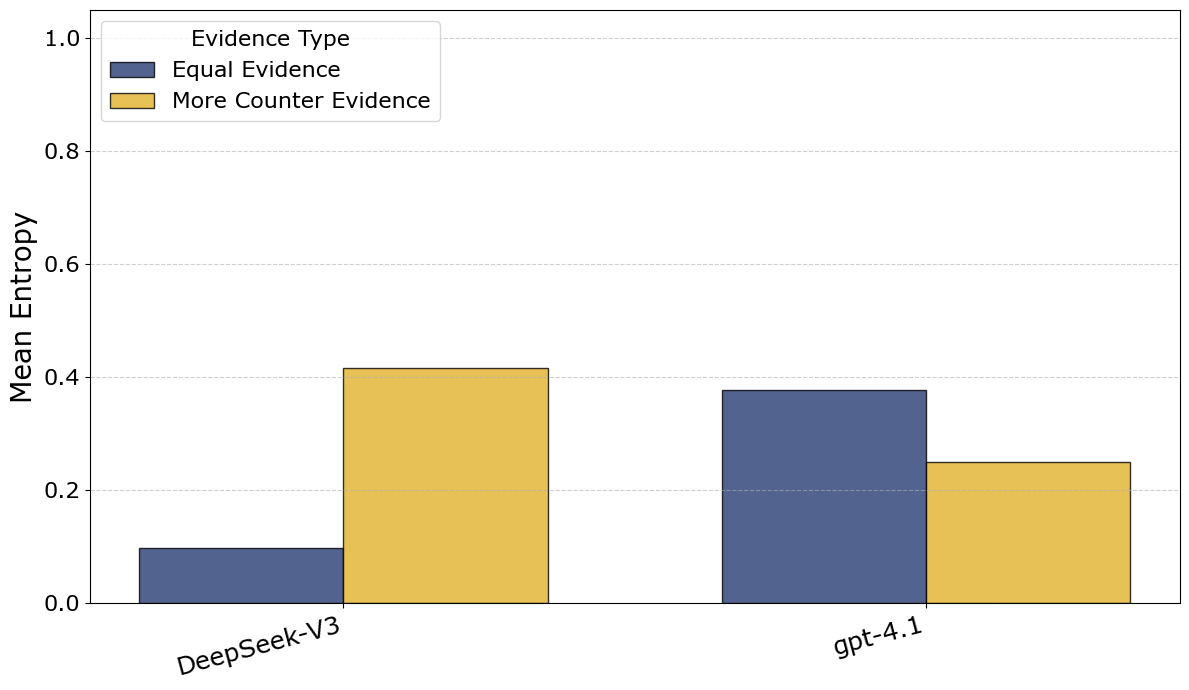

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os # 파일 경로 생성을 위해 추가

# --- 설정 부분 ---
# Mac에서 Verdana 폰트가 없을 경우, 'AppleGothic' 이나 'Malgun Gothic' (Windows) 등으로 변경
# 또는 컴퓨터에 설치된 다른 영문 폰트 사용
plt.rcParams['font.family'] = 'Verdana'

# 1. 비교할 모델 이름 리스트 정의
models_to_plot = [
    'DeepSeek-V3',
    'gpt-4.1',
]

# --- 데이터 로딩 및 전처리 ---
all_dfs = [] # 여러 데이터프레임을 담을 리스트

# 2. 각 모델별로 CSV 파일을 읽어와 리스트에 추가
for model_name in models_to_plot:
    # 파일 경로 생성
    file_path = f'./final_result/add/{model_name}-top-prob.csv'

    # 파일이 존재할 경우에만 처리
    if os.path.exists(file_path):
        temp_df = pd.read_csv(file_path)
        # 'model' 컬럼을 추가하여 어떤 모델의 데이터인지 명시
        temp_df['model'] = model_name
        all_dfs.append(temp_df)
    else:
        print(f"Warning: 파일이 존재하지 않습니다 - {file_path}")

# 3. 모든 데이터프레임을 하나로 합치기
if not all_dfs:
    raise ValueError("처리할 데이터 파일이 하나도 없습니다. 파일 경로와 모델 이름을 확인해주세요.")

df = pd.concat(all_dfs, ignore_index=True)


# --- 계산 부분 (기존과 거의 동일) ---
# 4. 확률 정규화 및 엔트로피 계산
df['prob_buy_norm'] = df['prob_buy'] / (df['prob_buy'] + df['prob_sell'])
df['prob_sell_norm'] = df['prob_sell'] / (df['prob_buy'] + df['prob_sell'])
df['entropy'] = df.apply(lambda row: entropy([row['prob_buy_norm'], row['prob_sell_norm']], base=2), axis=1)

# 5. 'model'과 'evidence_pair'로 그룹화하여 평균 엔트로피 계산
grouped = df.groupby(['model', 'evidence_pair'])['entropy'].mean().reset_index()

# evidence_pair를 설명적인 레이블로 변경
label_map = {
    '(2, 2)': 'Equal Evidence',
    '(2, 3)': 'More Counter Evidence'
}
grouped['evidence_label'] = grouped['evidence_pair'].map(label_map)


# --- 시각화 부분 ---
# 6. 피벗 테이블 생성 (index를 'model'로 변경)
# 모델 이름 순서를 models_to_plot 리스트 순서대로 정렬
pivot_df = grouped.pivot_table(index='model', columns='evidence_label', values='entropy', aggfunc='mean')
pivot_df = pivot_df.reindex(models_to_plot) # 지정한 순서대로 정렬

# 7. 그룹형 막대그래프 그리기
fig, ax = plt.subplots(figsize=(12, 7)) # Figure 크기 조정

bar_width = 0.35
indices = np.arange(len(pivot_df.index))
colors = ['#273c75', '#e1b12c']  # Deep navy & Citrus yellow

for i, label in enumerate(sorted(pivot_df.columns)):
    values = pivot_df[label]
    ax.bar(indices + i * bar_width, values, bar_width, label=label, color=colors[i], edgecolor='black', alpha=0.8)

# 축 및 레이블 설정
ax.set_ylabel('Mean Entropy', fontsize=20)
plt.yticks(fontsize=16)

ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(pivot_df.index, fontsize=18, rotation=15, ha='right') # 모델 이름이 길 경우 회전
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# 범례 설정
ax.legend(title='Evidence Type', fontsize=16, title_fontsize=16, loc='upper left')

# 레이아웃 및 저장
plt.tight_layout()
# plt.savefig("model_entropy_comparison.pdf")
plt.show()

In [125]:
sector = pd.read_csv("/Users/hobbang/Desktop/bias/final_result/DeepSeek-V3_sector_low_bias.csv")
size = pd.read_csv("/Users/hobbang/Desktop/bias/final_result/DeepSeek-V3_size_low_bias.csv")

common_tickers = set(sector['ticker']) & set(size['ticker'])

# 해당 티커 정보 추출 (sector와 size 모두에서)
common_sector = sector[sector['ticker'].isin(common_tickers)].reset_index(drop=True)
common_sector.to_csv("./final_result/DeepSeek-V3-no-prefer.csv", index=False)

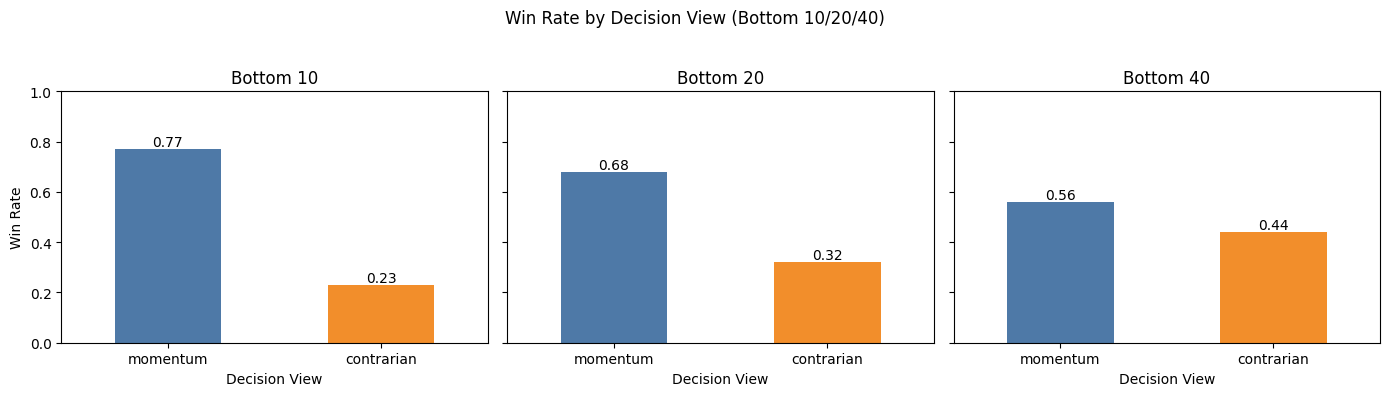

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

bottom_ns = [10, 20, 40]
file_template = "./gemini-2.5_bottom{}_mom.csv"

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
colors = ['#4e79a7', '#f28e2b']

for i, n in enumerate(bottom_ns):
    temp = pd.read_csv(file_template.format(n))
    all_views = temp['buy_view'].unique().tolist()

    def get_decision_view(row):
        buy_view = row['buy_view']
        llm_answer = row['llm_answer'].lower()
        other_view = [v for v in all_views if v != buy_view][0]
        if llm_answer == "buy":
            return buy_view
        elif llm_answer == "sell":
            return other_view
        else:
            return None

    temp['decision_view'] = temp.apply(get_decision_view, axis=1)
    counts = temp['decision_view'].value_counts()
    win_rate = counts / counts.sum()

    # bar plot
    ax = axs[i]
    bars = win_rate.plot(kind='bar', color=colors, ax=ax)
    ax.set_title(f'Bottom {n}')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Decision View')
    if i == 0:
        ax.set_ylabel('Win Rate')
    ax.bar_label(ax.containers[0], fmt='%.2f')
    ax.set_xticklabels(win_rate.index, rotation=0)

plt.suptitle('Win Rate by Decision View (Bottom 10/20/40)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [42]:
top_n = 40
MODEL_NAME = "gemini-2.5"
df = pd.read_csv(f'./final_result/{MODEL_NAME}_equal_evidence.csv')

# 1. sector 없이 ticker+name별 집계
ticker_grouped = df.groupby(['ticker', 'name']).agg(
    buy_count=('llm_answer', lambda x: (x.str.lower() == 'buy').sum()),
    sell_count=('llm_answer', lambda x: (x.str.lower() == 'sell').sum())
).reset_index()

ticker_grouped['total_count'] = ticker_grouped['buy_count'] + ticker_grouped['sell_count']
ticker_grouped['preference'] = (ticker_grouped['sell_count'] - ticker_grouped['buy_count']).abs() / ticker_grouped['total_count']
ticker_grouped['buy_ratio'] = ticker_grouped['buy_count'] / ticker_grouped['total_count']

# 2. 상위 20개
top_pref_df = ticker_grouped.sort_values('preference', ascending=False).head(top_n)
top_pref_df = top_pref_df[['ticker', 'name', 'buy_count', 'sell_count', 'total_count', 'buy_ratio', 'preference']]
top_pref_df = top_pref_df.reset_index(drop=True)
top_pref_df.to_csv(f"./{MODEL_NAME}_top{top_n}_preference.csv", index=False)

# 3. 하위 20개
bottom_pref_df = ticker_grouped.sort_values('preference', ascending=True).head(top_n)
bottom_pref_df = bottom_pref_df[['ticker', 'name', 'buy_count', 'sell_count', 'total_count', 'buy_ratio', 'preference']]
bottom_pref_df = bottom_pref_df.reset_index(drop=True)
bottom_pref_df.to_csv(f"./{MODEL_NAME}_bottom{top_n}_preference.csv", index=False)

print(f"\nPreference 상위 {top_n}개 주식이 {MODEL_NAME}_top{top_n}_preference.csv 파일로 저장되었습니다.")
print(top_pref_df.head(10))
print(f"\nPreference 하위 {top_n}개 주식이 {MODEL_NAME}_bottom{top_n}_preference.csv 파일로 저장되었습니다.")
print(bottom_pref_df.head(10))


Preference 상위 40개 주식이 gemini-2.5_top40_preference.csv 파일로 저장되었습니다.
  ticker                           name  buy_count  sell_count  total_count  \
0   QCOM          QUALCOMM Incorporated         10           0           10   
1    COO     The Cooper Companies, Inc.         10           0           10   
2   COST   Costco Wholesale Corporation         10           0           10   
3    LLY          Eli Lilly and Company         10           0           10   
4    LNT     Alliant Energy Corporation         10           0           10   
5    TFX          Teleflex Incorporated         10           0           10   
6   CTAS             Cintas Corporation         10           0           10   
7   PYPL          PayPal Holdings, Inc.         10           0           10   
8   ANSS                    ANSYS, Inc.         10           0           10   
9    TMO  Thermo Fisher Scientific Inc.         10           0           10   

   buy_ratio  preference  
0        1.0         1.0  
1       

In [300]:
import pandas as pd
import re

MODEL_NAME = "gpt-4.1"

def decide(row):
    if row['llm_answer'] == 'buy':
        return row['buy']
    elif row['llm_answer'] == 'sell':
        return row['sell']
    else:
        return None

def adjust_last_percent(evidence, delta):
    matches = list(re.finditer(r'(\d+(\.\d+)?)%', str(evidence)))
    if not matches:
        return evidence
    last = matches[-1]
    start, end = last.span(1)
    old_num = float(last.group(1))
    new_num = old_num + delta
    new_evidence = evidence[:start] + f"{new_num:.0f}" + evidence[end:]
    return new_evidence

def build_new_evidence_str(row, delta=1):
    e1_new, e2_new = row['evidence_1'], row['evidence_2']
    e1_changed = False
    e2_changed = False

    if row['llm_decision'] == 'contrarian':
        if row['view_1'] == 'momentum':
            e1_new = adjust_last_percent(row['evidence_1'], delta)
            e1_changed = True
        elif row['view_2'] == 'momentum':
            e2_new = adjust_last_percent(row['evidence_2'], delta)
            e2_changed = True
    elif row['llm_decision'] == 'momentum':
        if row['view_1'] == 'contrarian':
            e1_new = adjust_last_percent(row['evidence_1'], delta)
            e1_changed = True
        elif row['view_2'] == 'contrarian':
            e2_new = adjust_last_percent(row['evidence_2'], delta)
            e2_changed = True

    if e1_changed:
        return f"1. {e1_new}\n2. {row['evidence_2']}"
    elif e2_changed:
        return f"1. {row['evidence_1']}\n2. {e2_new}"
    else:
        return f"1. {row['evidence_1']}\n2. {row['evidence_2']}"

# 1. 원본 데이터 준비
df = pd.read_csv(f"./final_result/{MODEL_NAME}_mc.csv")
df['llm_decision'] = df.apply(decide, axis=1)
df = df.dropna()
unique_decision = df.groupby('ticker')['llm_decision'].nunique()
only_uniform_tickers = unique_decision[unique_decision == 1].index
filtered_df = df[df['ticker'].isin(only_uniform_tickers)].reset_index(drop=True)

# 2. delta별로 long format으로 변환
result_rows = []
for delta in [1, 3, 5, 10]:
    for _, row in filtered_df.iterrows():
        out_row = row.to_dict()
        out_row['delta'] = delta
        out_row['new_evidence_str'] = build_new_evidence_str(row, delta=delta)
        result_rows.append(out_row)

long_df = pd.DataFrame(result_rows)

long_df.to_csv(f"./evi/{MODEL_NAME}_mc_delta.csv", index=False)

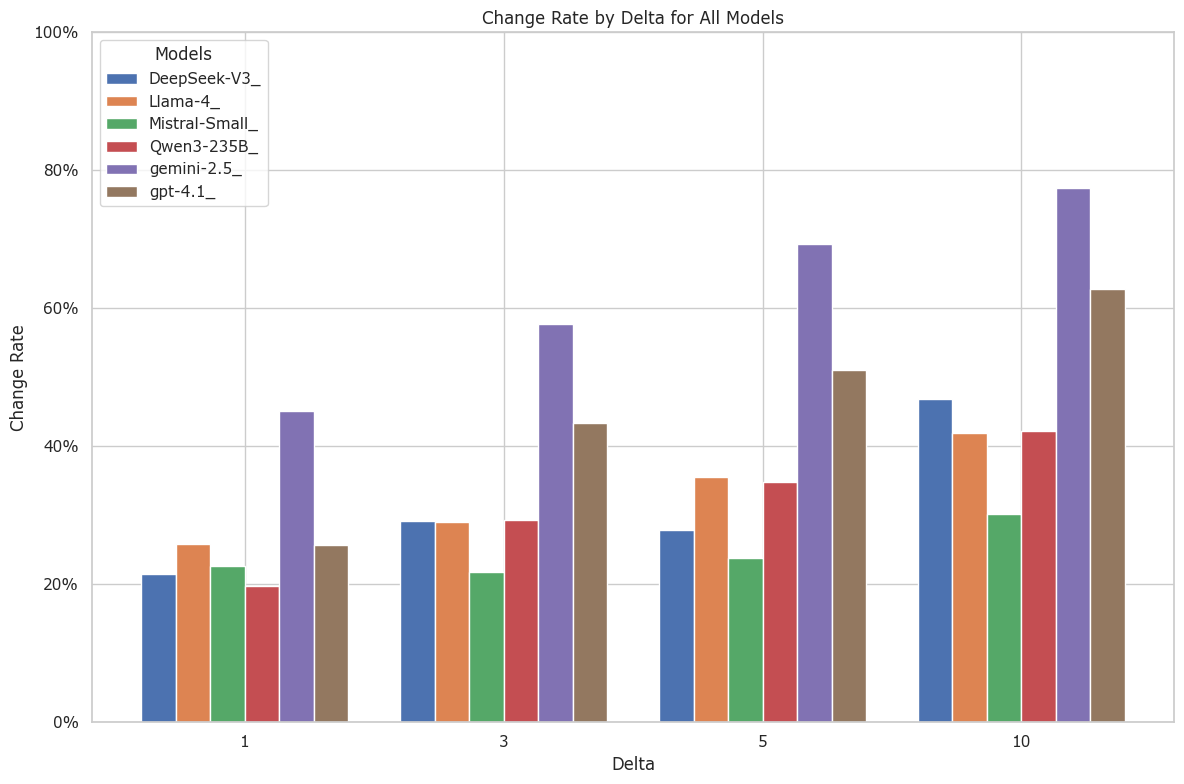

In [314]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np

# Directory containing the files
directory = "/Users/hobbang/Desktop/bias/final_result/"

# Find all files ending with _weight_mc.csv
files = glob(os.path.join(directory, "*_weight_mc.csv"))

# List to hold data from all models
all_data = []

# Process each file
for file_path in files:
    model_name = os.path.basename(file_path)[:-13]  # Assuming '_weight_mc.csv' is 13 characters

    # Read the CSV
    testing = pd.read_csv(file_path)

    # Compute llm_decision
    testing['llm_decision'] = testing.apply(
        lambda row: row['buy'] if row['llm_answer'] == 'buy' else (
            row['sell'] if row['llm_answer'] == 'sell' else None
        ),
        axis=1
    )

    # Compute is_change
    testing['is_change'] = testing['before_decision'] != testing['llm_decision']

    # Compute change rate by delta
    change_rate_by_delta = testing.groupby('delta')['is_change'].mean().reset_index()
    
    # Add model column
    change_rate_by_delta['model'] = model_name
    
    # Append to all_data
    all_data.append(change_rate_by_delta)

# Concatenate all data
if all_data:
    df_all = pd.concat(all_data)

    # Get unique deltas and models
    deltas = sorted(df_all['delta'].unique())
    models = sorted(df_all['model'].unique())

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust size as needed
    
    bar_width = 0.8 / len(models)  # Width of the bars
    
    positions = np.arange(len(deltas))
    
    for i, model in enumerate(models):
        model_data = df_all[df_all['model'] == model].sort_values('delta')
        # Assuming all models have the same deltas
        change_rates = model_data['is_change'].values  # Get the change rates
        
        ax.bar(positions + i * bar_width, change_rates, bar_width, label=model)

    # Set x-ticks to center of groups
    ax.set_xticks(positions + (len(models) - 1) / 2 * bar_width)
    ax.set_xticklabels(deltas)
    
    ax.set_xlabel('Delta')
    ax.set_ylabel('Change Rate')
    ax.set_title('Change Rate by Delta for All Models')
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(title='Models')
    
    plt.tight_layout()
    plt.show()
else:
    print("No files found.")

In [320]:
qual = pd.read_csv("/Users/hobbang/Desktop/bias/evi/gemini_quant_ver3.csv")
qual

,ticker,opinion,evidence1,evidence2
0,AES,buy,Analysis of AES's recently secured contracts f...,"In the most recent quarter, the company's cons..."
1,AES,sell,A sensitivity analysis of AES's debt structure...,An internal review of AES's capital project pi...
2,SJM,buy,Analysis of recent supply chain optimizations ...,The company's market share in the high-growth ...
3,SJM,sell,Internal forecasts indicate a 120 basis point ...,Recent syndicated retail data reveals a 90 bas...
4,HON,buy,Honeywell's Aerospace Technologies segment ope...,The Performance Materials and Technologies (PM...
...,...,...,...,...
849,COR,sell,Analysis of recent contract renewals indicates...,Our proprietary channel checks reveal a slowdo...
850,DOC,buy,Analysis of leasing agreements signed in the l...,The company's recently announced disposition o...
851,DOC,sell,Internal analysis of the Life Science portfoli...,The company's Net Debt to Adjusted EBITDA rati...
852,CPAY,buy,Corpay's adjusted EBITDA margin expanded by 12...,Internal projections for Corpay's new corporat...
